In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching gold data from yahoo finance
data = yf.Ticker('GC=F')
data = yf.download('GC=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
5911,2024-03-22,2179.199951,2179.600098,2157.500000,2158.100098,2158.100098,19
5912,2024-03-25,2166.199951,2179.399902,2166.199951,2174.800049,2174.800049,79
5913,2024-03-26,2182.699951,2182.699951,2175.600098,2175.600098,2175.600098,202373
5914,2024-03-27,2179.399902,2196.199951,2172.100098,2190.600098,2190.600098,202373


In [35]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-08-30,273.899994
1,2000-08-31,278.299988
2,2000-09-01,277.000000
3,2000-09-05,275.799988
4,2000-09-06,274.200012
...,...,...
5911,2024-03-22,2158.100098
5912,2024-03-25,2174.800049
5913,2024-03-26,2175.600098
5914,2024-03-27,2190.600098


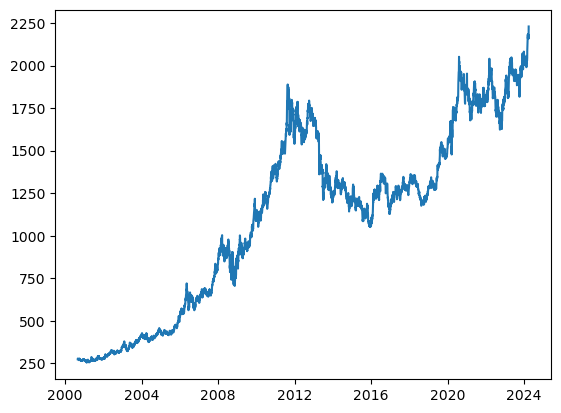

In [36]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [37]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [38]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

#any greater lookback doesn't capture the volatility of gold 
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-09-11,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988,273.899994
2000-09-12,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988
2000-09-13,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000
2000-09-14,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988
2000-09-15,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012
...,...,...,...,...,...,...,...,...
2024-03-22,2158.100098,2182.399902,2157.899902,2156.300049,2160.699951,2157.300049,2163.000000,2175.399902
2024-03-25,2174.800049,2158.100098,2182.399902,2157.899902,2156.300049,2160.699951,2157.300049,2163.000000
2024-03-26,2175.600098,2174.800049,2158.100098,2182.399902,2157.899902,2156.300049,2160.699951,2157.300049


In [39]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 273.1000061 ,  273.29998779,  274.        , ...,  277.        ,
         278.29998779,  273.8999939 ],
       [ 272.8999939 ,  273.1000061 ,  273.29998779, ...,  275.79998779,
         277.        ,  278.29998779],
       [ 272.79998779,  272.8999939 ,  273.1000061 , ...,  274.20001221,
         275.79998779,  277.        ],
       ...,
       [2175.60009766, 2174.80004883, 2158.10009766, ..., 2156.30004883,
        2160.69995117, 2157.30004883],
       [2190.60009766, 2175.60009766, 2174.80004883, ..., 2157.89990234,
        2156.30004883, 2160.69995117],
       [2229.60009766, 2190.60009766, 2175.60009766, ..., 2182.39990234,
        2157.89990234, 2156.30004883]])

In [40]:
shifted_df_as_np.shape

(5909, 8)

In [41]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.98176754, -0.98119351, -0.98038809, ..., -0.97727509,
        -0.97592614, -0.98049187],
       [-0.98197013, -0.98140016, -0.98111447, ..., -0.97852031,
        -0.97727509, -0.97592614],
       [-0.98207143, -0.98160683, -0.98132199, ..., -0.98018055,
        -0.97852031, -0.97727509],
       ...,
       [ 0.94530261,  0.98367342,  0.97468102, ...,  0.97281317,
         0.9773788 ,  0.97385083],
       [ 0.96049633,  0.98450013,  0.99201001, ...,  0.97447328,
         0.97281317,  0.9773788 ],
       [ 1.        ,  1.        ,  0.9928402 , ...,  0.99989613,
         0.97447328,  0.97281317]])

In [42]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5909, 7), (5909,))

In [43]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98049187, -0.97592614, -0.97727509, ..., -0.98018055,
        -0.98038809, -0.98119351],
       [-0.97592614, -0.97727509, -0.97852031, ..., -0.98038809,
        -0.98111447, -0.98140016],
       [-0.97727509, -0.97852031, -0.98018055, ..., -0.98111447,
        -0.98132199, -0.98160683],
       ...,
       [ 0.97385083,  0.9773788 ,  0.97281317, ...,  0.99989613,
         0.97468102,  0.98367342],
       [ 0.9773788 ,  0.97281317,  0.97447328, ...,  0.97468102,
         0.99201001,  0.98450013],
       [ 0.97281317,  0.97447328,  0.99989613, ...,  0.99201001,
         0.9928402 ,  1.        ]])

In [44]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5613

In [45]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5613, 7), (296, 7), (5613,), (296,))

In [46]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5613, 7, 1), (296, 7, 1), (5613, 1), (296, 1))

In [47]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5613, 7, 1]),
 torch.Size([296, 7, 1]),
 torch.Size([5613, 1]),
 torch.Size([296, 1]))

In [48]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [49]:
train_dataset

In [50]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [52]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
#model = LSTM(1, 4, 1)
#Attempt 2:  Increase to 8 hidden units and 2 stacked layers
#model = LSTM(1, 8, 2)  
#Attempt 3:  Increase to 16 hidden units and 4 stacked layers
#model = LSTM(1, 16, 4)
#Attempt 4: Inrcease to 32 hidden unit and 8 stacked layers <----overfitted
#model = LSTM(1, 32, 8)
#Attempt 5:  Increase to 24 hidden units and 6 stacked layers
#model = LSTM(1, 24, 6)
#Attempt 6: 16 hidden units and 1 stacked layer
#model = LSTM(1, 16, 1)
#Attempt 7: 12 hidden units and 1 stacked layer
model = LSTM(1,12,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [53]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [54]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [55]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.164
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.014
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
*****************

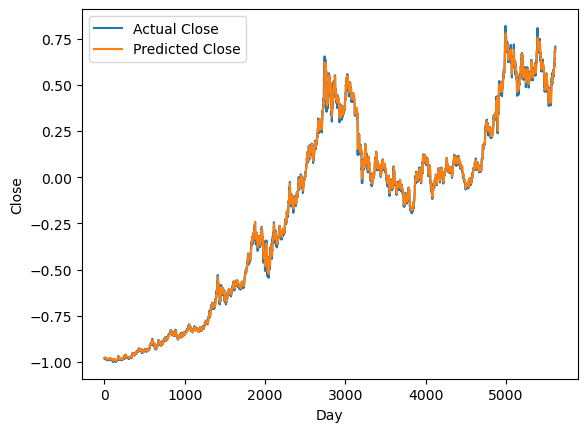

In [56]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [57]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([ 277.43291873,  277.01629834,  276.47716331, ..., 1915.70487695,
       1919.8437181 , 1924.4578478 ])

In [58]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 273.1000078 ,  272.89999471,  272.79995874, ..., 1927.0999743 ,
       1933.90000763, 1941.19992659])

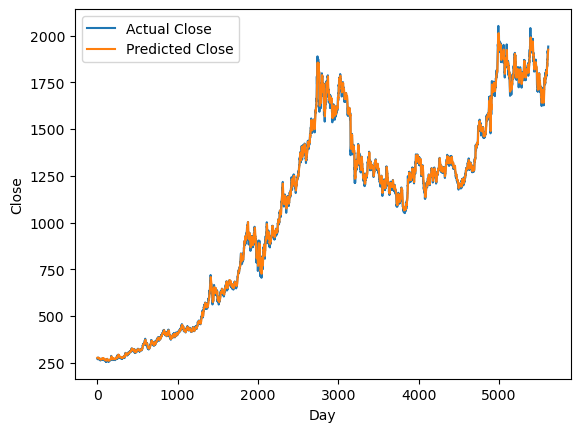

In [59]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [60]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1929.97300736, 1930.08081083, 1929.07091829, 1926.28085624,
       1926.05359805, 1925.65580796, 1921.90045764, 1902.22273504,
       1887.28012681, 1879.05440437, 1876.30947619, 1872.17852023,
       1868.65442954, 1863.13673965, 1859.52738301, 1850.87132936,
       1846.80027729, 1844.2321774 , 1840.50495485, 1837.62986222,
       1831.31000155, 1823.58934307, 1820.61009534, 1823.17095733,
       1828.82246004, 1832.07003954, 1838.67235472, 1843.61654428,
       1835.71111347, 1827.79155995, 1827.35693308, 1838.62321941,
       1863.94361802, 1882.13933715, 1900.40625835, 1910.16894521,
       1930.599056  , 1948.27311697, 1947.475183  , 1946.90744944,
       1960.11472782, 1967.29466246, 1962.50070339, 1963.64311417,
       1963.19201079, 1966.71580726, 1966.08858173, 1969.89465616,
       1984.60006146, 1995.75560208, 2000.51872653, 1996.04529448,
       1996.0191086 , 1997.86612567, 2008.1890728 , 2005.20452906,
       1999.32135481, 1998.5288934 , 1994.68804175, 1995.28643

In [61]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1929.09998757, 1928.59998425, 1922.90005236, 1929.50001376,
       1927.80004956, 1916.30003213, 1862.90000747, 1866.19995874,
       1871.69993638, 1877.4000448 , 1866.19995874, 1862.80003035,
       1851.9000522 , 1853.99998375, 1834.19992303, 1842.00002184,
       1840.40003477, 1833.00002099, 1832.00001436, 1817.99998035,
       1808.80002525, 1816.99997372, 1828.90001734, 1837.69994625,
       1833.50002431, 1847.69995373, 1847.90002567, 1813.90003554,
       1812.69995696, 1829.30004353, 1861.99997796, 1911.69996631,
       1906.19992983, 1926.59997098, 1919.00000296, 1969.80003391,
       1979.19994326, 1938.00001129, 1946.80005789, 1993.8000754 ,
       1982.09998603, 1952.40001265, 1972.40002761, 1966.0999976 ,
       1980.3000447 , 1968.99998152, 1983.90004504, 2022.19993424,
       2020.89999623, 2011.89999538, 1989.09997361, 2004.80003067,
       2010.90004759, 2041.30003739, 2002.19997812, 1994.19992506,
       2007.40002438, 1995.19993169, 2007.59997863, 1979.49999

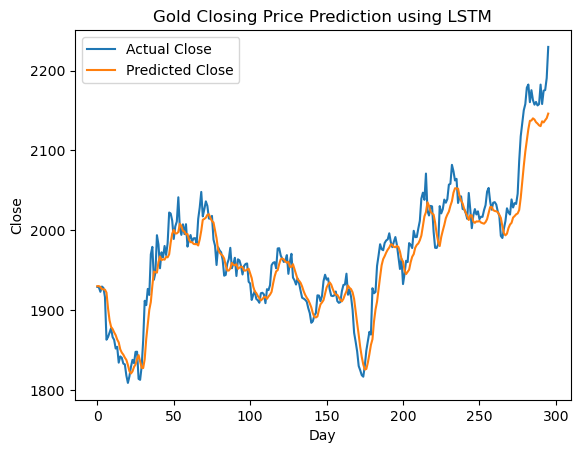

In [62]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Gold Closing Price Prediction using LSTM")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [63]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 23.96093060204525
Mean Absolute Error (MAE): 17.996893466784343
Mean Absolute Percentage Error (MAPE): 0.9036987366978909


In [64]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.017, MAE: 0.011, MAPE: 27.136%
Validation - RMSE: 0.024, MAE: 0.018, MAPE: 2.428%


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jackc\\Documents\\FYP_ML_Predict\\static\\images\\LSTM_Gold_PNG.png'

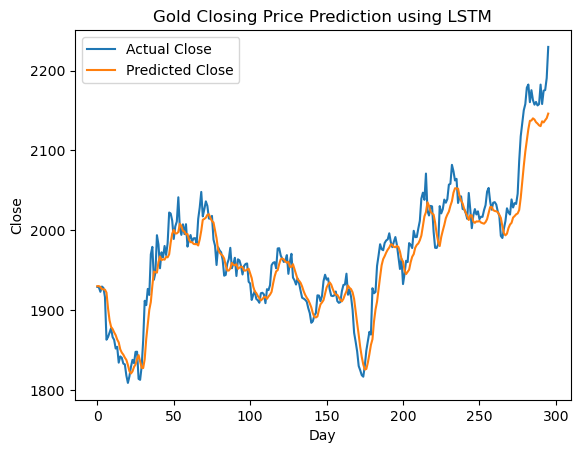

In [65]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Gold Closing Price Prediction using LSTM")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.savefig(r'C:\Users\jackc\Documents\FYP_ML_Predict\static\images\LSTM_Gold_PNG.png')
plt.show()
plt.clf()

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)
# Correcting the approach to reshape and inverse transform the prediction
latest_input = shifted_df_as_np[-1, 1:].reshape(1, lookback, 1)  # Reshape for LSTM: [1, lookback, 1]

# Convert to PyTorch tensor
latest_input_tensor = torch.tensor(latest_input).float().to(device)

# Make the prediction
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    prediction_scaled = model(latest_input_tensor).cpu().numpy()

# Prepare the data for inverse transformation correctly
prediction_scaled_expanded = np.expand_dims(prediction_scaled.flatten(), axis=0)
dummy_features = np.zeros((1, lookback))
combined_prediction = np.concatenate((prediction_scaled_expanded, dummy_features), axis=1)

# Inverse transform the prediction to get it back into the original scale
next_day_price = scaler.inverse_transform(combined_prediction)[0, 0]

print(f'Predicted Gold price for tomorrow: {next_day_price}')
import pickle
model_info = {
    'next_day_price': next_day_price,
    'rmse': rmse,
    'mae': mae,
    'mape': mape
}
with open(r'C:\Users\jackc\Documents\FYP_ML_Predict\models\LSTM_Gold.pkl', 'wb') as pkl:
    pickle.dump(model_info, pkl)



In [ ]:
def predict_next_7_days(model, scaler, last_7_days, N=7):
    model.eval()  # Ensure the model is in evaluation mode
    current_input = last_7_days
    
    for _ in range(N):
        # Convert current input to tensor
        current_input_tensor = torch.tensor(current_input).float().to(device)
        
        with torch.no_grad():
            # Predict the next day
            predicted_price_scaled = model(current_input_tensor).cpu().numpy()
            # Assuming the output is 2D, we reshape it to fit our expected input shape for the next step
            next_day_price_scaled = predicted_price_scaled.reshape(1, 1, -1)  # Adjust this line if needed
            
            # Prepare for next day prediction by updating the input
            current_input = np.append(current_input[:, 1:, :], next_day_price_scaled, axis=1)
    
    # The last prediction is the day we're interested in, reverse scaling
    last_prediction_scaled = current_input[0, -1, :].reshape(1, -1)
    dummy_array = np.zeros((1, scaler.n_features_in_))
    dummy_array[:, 0] = last_prediction_scaled  # Use the first feature assuming it's the 'Close' price
    
    # Inverse transform to get the original scale
    last_prediction = scaler.inverse_transform(dummy_array)[:, 0]

    return last_prediction[0]

# Let's ensure that last_7_days_scaled is correctly shaped as (1, 7, 1) before prediction
last_7_days_scaled = last_7_days_scaled.reshape(1, -1, 1)

# Now, you can call your predict_next_N_days function again with this correctly shaped input
price_in_7_days = predict_next_7_days(model, scaler, last_7_days_scaled, N=7)
print(f'Predicted gold price in 7 days: {price_in_7_days}')




In [ ]:
import numpy as np
import torch

def predict_price_in_N_days(model, scaler, last_N_days_scaled, N=30):
    model.eval()  # Set the model to evaluation mode
    current_input = last_N_days_scaled  # Starting input

    with torch.no_grad():
        for _ in range(N):
            # Predict the next day
            current_input_tensor = torch.tensor(current_input).float().to(device)
            predicted_price_scaled = model(current_input_tensor).cpu().numpy()
            
            # Prepare the input for the next prediction
            next_input_scaled = np.append(current_input[:, :, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)
            current_input = next_input_scaled

    # Last prediction is the price after N days
    predicted_price_scaled = predicted_price_scaled[0, 0]  # Extract the predicted price
    dummy_array = np.zeros((1, 8))  # Adjust the size based on your scaler's expected feature input
    dummy_array[:, 0] = predicted_price_scaled

    predicted_price = scaler.inverse_transform(dummy_array)[:, 0]

    return predicted_price.item()

# Assuming last_7_days_scaled is defined and shaped correctly as per your LSTM model's input requirements
# Predict the gold price exactly 30 days into the future
predicted_price_in_30_days = predict_price_in_N_days(model, scaler, last_7_days_scaled, N=30)

# Display the predicted price
print(f'Predicted gold price in 30 days: {predicted_price_in_30_days}')